<a href="https://colab.research.google.com/github/ronen-shachar/ATS-HW2/blob/main/MQ_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%matplotlib inline

In [18]:
!git remote add origin git@github.com:ronen-shachar/ATS-HW2.git
!git branch -M main
!git push -u origin main


fatal: remote origin already exists.
error: refname refs/heads/master not found
fatal: Branch rename failed
error: src refspec main does not match any.
error: failed to push some refs to 'git@github.com:ronen-shachar/ATS-HW2.git'


In [13]:
import torch
from torch import nn
import torch.nn.functional as F 
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
import util
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from time import time
import argparse
from datetime import date
from progressbar import *

class Decoder(nn.Module):

    def __init__(
        self, 
        input_size, 
        output_horizon,
        encoder_hidden_size, 
        decoder_hidden_size, 
        output_size):
        super(Decoder, self).__init__()
        self.global_mlp = nn.Linear(output_horizon * (encoder_hidden_size + input_size), \
                (output_horizon+1) * decoder_hidden_size)
        self.local_mlp = nn.Linear(decoder_hidden_size * 2 + input_size, output_size)
        self.decoder_hidden_size = decoder_hidden_size
    
    def forward(self, ht, xf):
        '''
        Args:
        ht (tensor): (1, hidden_size)
        xf (tensor): (output_horizon, num_features)
        '''
        num_ts, output_horizon, num_features = xf.size()
        num_ts, hidden_size = ht.size()
        ht = ht.unsqueeze(1)
        ht = ht.expand(num_ts, output_horizon, hidden_size)
        # inp = (xf + ht).view(batch_size, -1) # batch_size, hidden_size, output_horizon
        inp = torch.cat([xf, ht], dim=2).view(num_ts, -1)
        contexts = self.global_mlp(inp)
        contexts = contexts.view(num_ts, output_horizon+1, self.decoder_hidden_size)
        ca = contexts[:, -1, :].view(num_ts, -1)
        C = contexts[:, :-1, :]
        C = F.relu(C)
        y = []
        for i in range(output_horizon):
            ci = C[:, i, :].view(num_ts, -1)
            xfi = xf[:, i, :].view(num_ts, -1)
            inp = torch.cat([xfi, ci, ca], dim=1)
            out = self.local_mlp(inp) # num_ts, num_quantiles
            y.append(out.unsqueeze(1))
        y = torch.cat(y, dim=1) # batch_size, output_horizon, quantiles
        return y 


class MQRNN(nn.Module):

    def __init__(
        self, 
        output_horizon, 
        num_quantiles, 
        input_size, 
        embedding_size=10,
        encoder_hidden_size=64, 
        encoder_n_layers=3,
        decoder_hidden_size=64
        ):
        '''
        Args:
        output_horizon (int): output horizons to output in prediction
        num_quantiles (int): number of quantiles interests, e.g. 0.25, 0.5, 0.75
        input_size (int): feature size
        embedding_size (int): embedding size
        encoder_hidden_size (int): hidden size in encoder
        encoder_n_layers (int): encoder number of layers
        decoder_hidden_size (int): hidden size in decoder
        '''
        super(MQRNN, self).__init__()
        self.output_horizon = output_horizon
        self.encoder_hidden_size = encoder_hidden_size
        self.input_embed = nn.Linear(1, embedding_size) # time series embedding
        self.encoder = nn.LSTM(input_size + embedding_size, encoder_hidden_size, \
                    encoder_n_layers, bias=True, batch_first=True)
        self.decoder = Decoder(input_size, output_horizon, encoder_hidden_size,\
                    decoder_hidden_size, num_quantiles)
    
    def forward(self, X, y, Xf):
        '''
        Args:
        X (tensor like): shape (num_time_series, num_periods, num_features)
        y (tensor like): shape (num_time_series, num_periods)
        Xf (tensor like): shape (num_time_series, seq_len, num_features)
        '''
        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).float()
            Xf = torch.from_numpy(Xf).float()
        num_ts, num_periods, num_features = X.size()
        y = y.unsqueeze(2)
        y = self.input_embed(y)
        x = torch.cat([X, y], dim=2)
        # x = x.unsqueeze(0) # batch, seq_len, embed + num_features
        _, (h, c) = self.encoder(x)
        ht = h[-1, :, :]
        # global mlp
        ht = F.relu(ht)
        ypred = self.decoder(ht, Xf)
        return ypred

def batch_generator(X, y, num_obs_to_train, seq_len, batch_size):
    '''
    Args:
    X (array like): shape (num_samples, num_features, num_periods)
    y (array like): shape (num_samples, num_periods)
    num_obs_to_train (int)
    seq_len (int): sequence/encoder/decoder length
    '''
    num_ts, num_periods, _ = X.shape
    if num_ts < batch_size:
        batch_size = num_ts
    t = random.choice(range(num_obs_to_train, num_periods-seq_len))
    batch = random.sample(range(num_ts), batch_size)
    X_train_batch = X[batch, t-num_obs_to_train:t, :]
    y_train_batch = y[batch, t-num_obs_to_train:t]
    Xf = X[batch, t:t+seq_len, :]
    yf = y[batch, t:t+seq_len]
    return X_train_batch, y_train_batch, Xf, yf

def train(
    X, 
    y,
    args,
    quantiles
    ):
    num_ts, num_periods, num_features = X.shape
    num_quantiles = len(quantiles)
    model = MQRNN(
        args.seq_len, 
        num_quantiles, 
        num_features, 
        args.embedding_size,
        args.encoder_hidden_size, 
        args.n_layers,
        args.decoder_hidden_size
        )
    optimizer = Adam(model.parameters(), lr=args.lr)
    Xtr, ytr, Xte, yte = util.train_test_split(X, y)
    losses = []
    yscaler = None
    if args.standard_scaler:
        yscaler = util.StandardScaler()
    elif args.log_scaler:
        yscaler = util.LogScaler()
    elif args.mean_scaler:
        yscaler = util.MeanScaler()
    if yscaler is not None:
        ytr = yscaler.fit_transform(ytr)
    num_obs_to_train = args.num_obs_to_train
    seq_len = args.seq_len
    progress = ProgressBar()
    for epoch in progress(range(args.num_epoches)):
        # print("Epoch {} start...".format(epoch))
        for step in range(args.step_per_epoch):
            X_train_batch, y_train_batch, Xf, yf = batch_generator(Xtr, ytr, 
                    num_obs_to_train, args.seq_len, args.batch_size)
            X_train_tensor = torch.from_numpy(X_train_batch).float()
            y_train_tensor = torch.from_numpy(y_train_batch).float() 
            Xf = torch.from_numpy(Xf).float()
            yf = torch.from_numpy(yf).float()
            ypred = model(X_train_tensor, y_train_tensor, Xf)
        
            # quantile loss
            loss = torch.zeros_like(yf)
            num_ts = Xf.size(0)
            for q, rho in enumerate(quantiles):
                ypred_rho = ypred[:, :, q].view(num_ts, -1)
                e = ypred_rho - yf
                loss += torch.max(rho * e, (rho - 1) * e)
            loss = loss.mean()

            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    mape_list = []
    X_test = Xte[:, -seq_len-num_obs_to_train:-seq_len, :].reshape((num_ts, -1, num_features))
    Xf_test = Xte[:, -seq_len:, :].reshape((num_ts, -1, num_features))
    y_test = yte[:, -seq_len-num_obs_to_train:-seq_len].reshape((num_ts, -1))
    if yscaler is not None:
        y_test = yscaler.transform(y_test)
    yf_test = yte[:, -seq_len:]
    ypred = model(X_test, y_test, Xf_test) # (1, num_quantiles, output_horizon)
    ypred = ypred.data.numpy()
    if yscaler is not None:
        ypred = yscaler.inverse_transform(ypred)
    ypred = np.maximum(0, ypred)

    # P50 quantile MAPE 
    mape = util.MAPE(yf_test, ypred[:, :, 1])
    print("MAPE: {}".format(mape))
    mape_list.append(mape)

    if args.show_plot:
        show_idx = 0
        plt.figure(1, figsize=(20, 5))
        plt.plot([k + seq_len + num_obs_to_train - seq_len \
            for k in range(seq_len)], ypred[show_idx, :, 1], "r-")
        plt.fill_between(x=[k + seq_len + num_obs_to_train - seq_len for k in range(seq_len)], \
            y1=ypred[show_idx, :, 0], y2=ypred[show_idx, :, 2], alpha=0.5)
        plt.title('Prediction uncertainty')
        yplot = yte[show_idx, -seq_len-num_obs_to_train:]
        plt.plot(range(len(yplot)), yplot, "k-")
        plt.legend(["P50 forecast", "true", "P10-P90 quantile"], loc="upper left")
        ymin, ymax = plt.ylim()
        plt.vlines(seq_len + num_obs_to_train - seq_len, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        plt.ylim(ymin, ymax)
        plt.xlabel("Periods")
        plt.ylabel("Y")
        plt.show()
    return losses, mape_list



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
100% (100 of 100) |######################| Elapsed Time: 0:00:33 Time:  0:00:33


MAPE: 0.09086580110007896


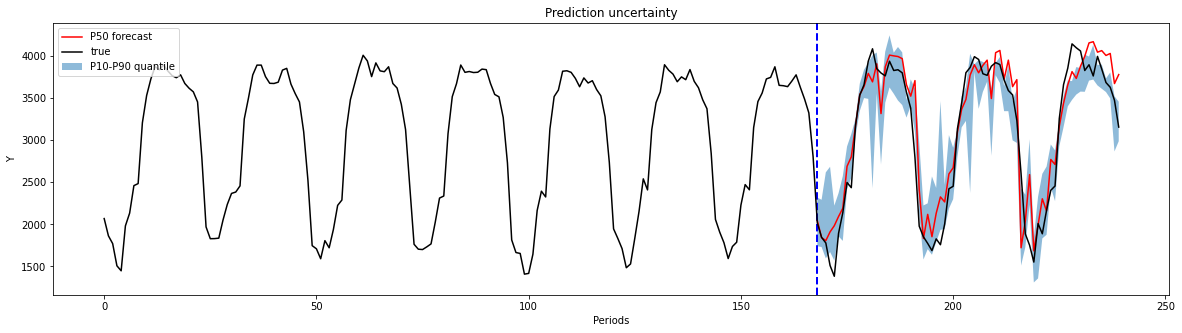

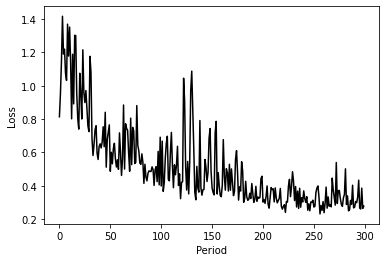

In [14]:
# from pandas.core.tools.datetimes import to_datetime
parser = argparse.ArgumentParser()
parser.add_argument("--num_epoches", "-e", type=int, default=1000)
parser.add_argument("--step_per_epoch", "-spe", type=int, default=2)
parser.add_argument("-lr", type=float, default=1e-3)
parser.add_argument("--n_layers", "-nl", type=int, default=3)
parser.add_argument("--encoder_hidden_size", "-ehs", type=int, default=64)
parser.add_argument("--decoder_hidden_size", "-dhs", type=int, default=64)
parser.add_argument("--seq_len", "-sl", type=int, default=7)
parser.add_argument("--num_obs_to_train", "-not", type=int, default=1)
parser.add_argument("--embedding_size", "-es", type=int, default=10)
parser.add_argument("--standard_scaler", "-ss", action="store_true")
parser.add_argument("--log_scaler", "-ls", action="store_true")
parser.add_argument("--mean_scaler", "-ms", action="store_true")
parser.add_argument("--show_plot", "-sp", action="store_true")
parser.add_argument("--run_test", "-rt", action="store_true")
parser.add_argument("--batch_size", "-b", type=int, default=64)
args = parser.parse_args([
"-e",
"100",
"-spe",
"3",
"-nl",
"1",
"-sp",
"-sl",
"72",
"-not",
"168",
"-rt",
"-ehs",
"50",
"-dhs",
"20",
"-ss",
"-es",
"10",
"-ms"]
)

if args.run_test:
    data_path = util.get_data_path()
    data = pd.read_csv(os.path.join(data_path, "LD_MT200_hour.csv"), parse_dates=["date"])
    data["year"] = data["date"].apply(lambda x: x.year)
    data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
    data = data.loc[(data["date"] >= pd.datetime(2014, 1, 1)) & (data["date"] <= pd.datetime(2014, 3, 1))]

    features = ["hour", "day_of_week"]
    # hours = pd.get_dummies(data["hour"])
    # dows = pd.get_dummies(data["day_of_week"])
    hours = data["hour"]
    dows = data["day_of_week"]
    X = np.c_[np.asarray(hours), np.asarray(dows)]
    num_features = X.shape[1]
    num_periods = len(data)
    X = np.asarray(X).reshape((-1, num_periods, num_features))
    y = np.asarray(data["MT_200"]).reshape((-1, num_periods))
    quantiles = [0.1, 0.5, 0.9]
    losses, mape_list = train(X, y, args, quantiles)
    if args.show_plot:
        plt.plot(range(len(losses)), losses, "k-")
        plt.xlabel("Period")
        plt.ylabel("Loss")
        plt.show()